In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
from glob import glob
import IPython.display as ipd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import os

In [2]:
# Load metadata
df = pd.read_csv("/content/drive/MyDrive/BirdCall Identification Project/bird_songs_metadata.csv")
df.head()

,id,genus,species,subspecies,name,recordist,country,location,latitude,longitude,altitude,sound_type,source_url,license,time,date,remarks,filename
0,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-0.wav
1,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-1.wav
2,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-4.wav
3,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-5.wav
4,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-6.wav


In [25]:
class_names = df["name"].unique()
print(class_names)

["Bewick's Wren" 'Northern Mockingbird' 'American Robin' 'Song Sparrow'
 'Northern Cardinal']


In [26]:
df["name"].value_counts()

,count
name,
Song Sparrow,1256
Northern Mockingbird,1182
Northern Cardinal,1074
American Robin,1017
Bewick's Wren,893


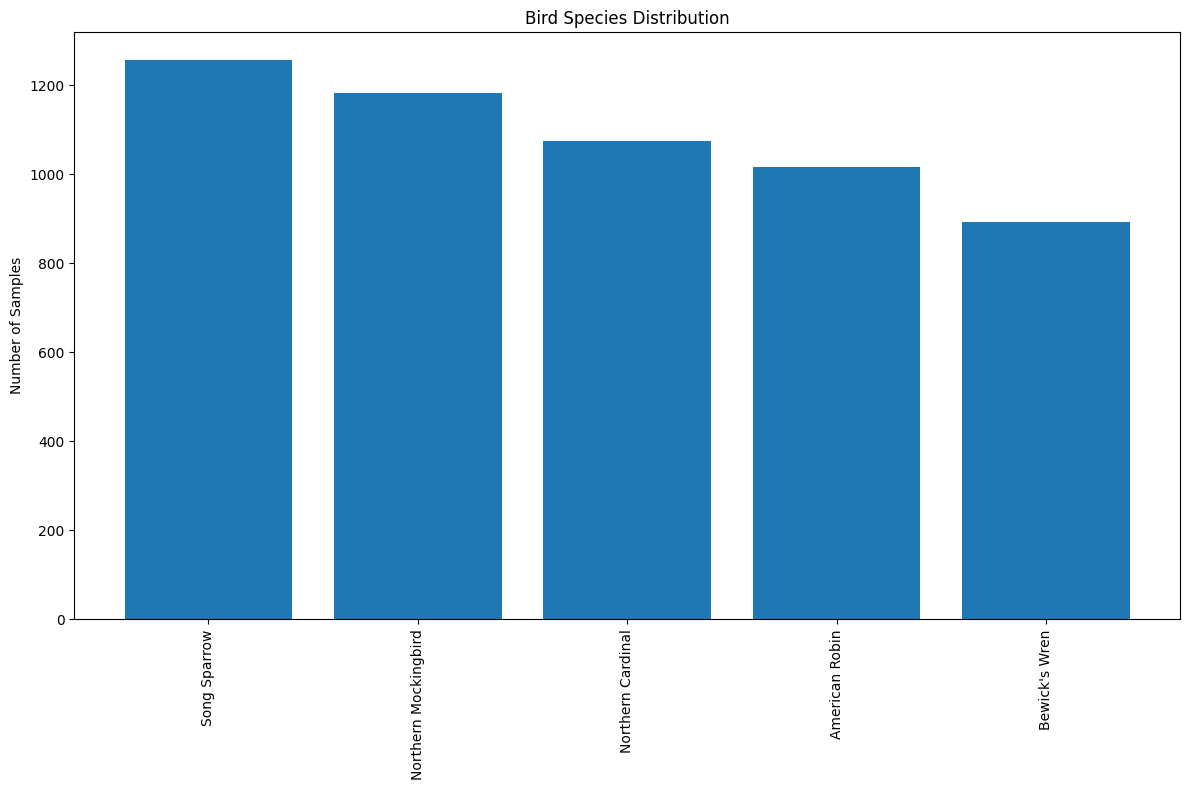

In [27]:
plt.figure(figsize=(12, 8))
counts = df["name"].value_counts()
plt.bar(counts.index, counts.values)
plt.xticks(rotation=90)  # Rotate species names for readability
plt.ylabel("Number of Samples")
plt.title("Bird Species Distribution")
plt.tight_layout()  # Prevent label cutoff
plt.show()

In [3]:
# Define paths
path_to_wav = "/content/drive/MyDrive/BirdCall Identification Project/WavFiles/"
datafiles = glob(path_to_wav + "*.wav")

In [31]:
# Parameters
SAMPLE_RATE = 22050  # Standard sample rate for audio
DURATION = 5  # Duration in seconds for each sample
N_MELS = 128  # Number of Mel bands
HOP_LENGTH = 512  # Hop length for STFT
N_FFT = 2048  # Number of FFT components

In [32]:
# Function to generate mel spectrogram
def generate_mel_spectrogram(audio_path, duration=DURATION, sr=SAMPLE_RATE, n_mels=N_MELS,
                            hop_length=HOP_LENGTH, n_fft=N_FFT):
    try:
        # Load audio file
        y, sr = librosa.load(audio_path, sr=sr, duration=duration)

        # If audio is shorter than duration, pad with zeros
        if len(y) < sr * duration:
            padding = sr * duration - len(y)
            y = np.pad(y, (0, padding), mode='constant')

        # Generate mel spectrogram
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels,
                                          hop_length=hop_length, n_fft=n_fft)
        S_dB = librosa.power_to_db(S, ref=np.max)

        # Normalize to 0-1 range
        S_dB = (S_dB - S_dB.min()) / (S_dB.max() - S_dB.min())

        # Add channel dimension for CNN
        S_dB = np.expand_dims(S_dB, axis=-1)

        return S_dB
    except Exception as e:
        print(f"Error processing {audio_path}: {str(e)}")
        return None

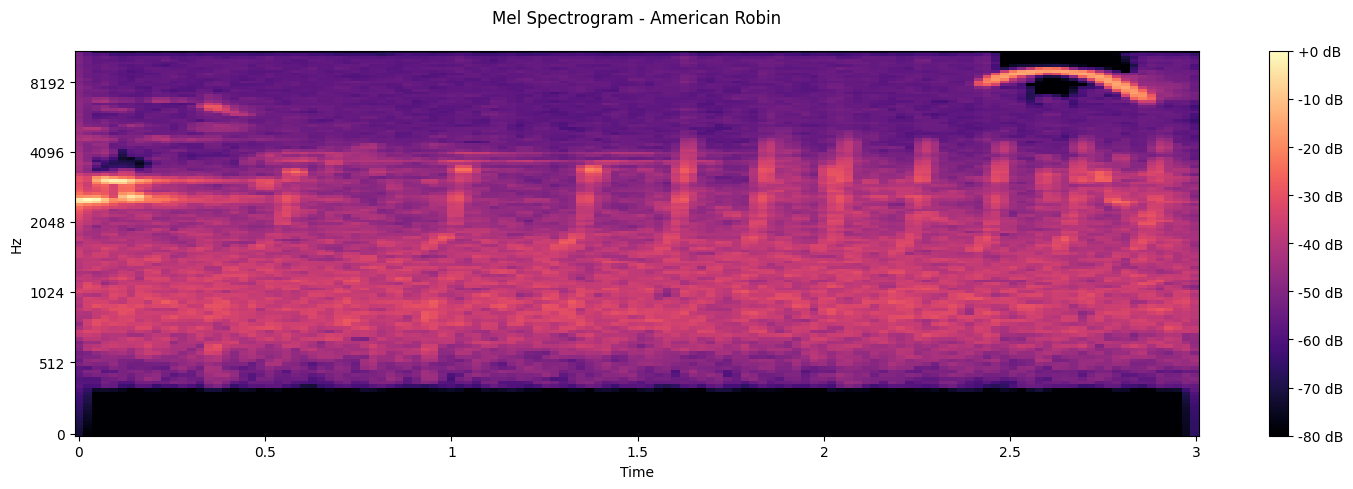

In [33]:
i = np.random.randint(0, df.shape[0])
generate_spectrogram(df.loc[i, "filename"], df.loc[i, "name"])

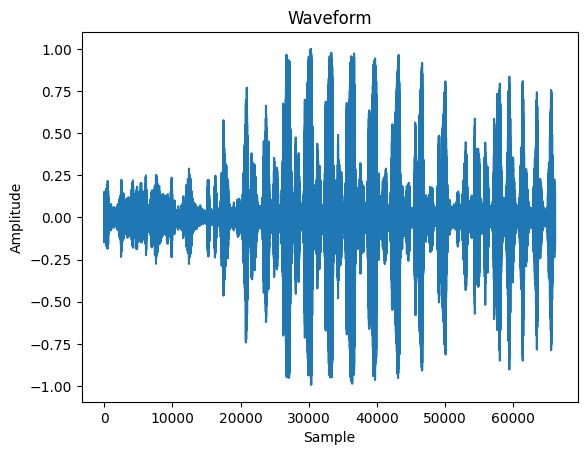

In [34]:
filename = "/content/drive/MyDrive/BirdCall Identification Project/WavFiles/101308-0.wav"
audio_data, sample_rate = librosa.load(filename)

plt.plot(audio_data)
plt.title("Waveform")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.show()

In [6]:
# Prepare dataset
def prepare_dataset(df, path_to_wav, test_size=0.2, random_state=42):
    # Filter only files that exist
    existing_files = []
    labels = []

    for idx, row in df.iterrows():
        file_path = os.path.join(path_to_wav, row['filename'])
        if os.path.exists(file_path):
            existing_files.append(file_path)
            labels.append(row['name'])

    # Encode labels
    le = LabelEncoder()
    encoded_labels = le.fit_transform(labels)
    num_classes = len(le.classes_)

    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        existing_files, encoded_labels,
        test_size=test_size,
        random_state=random_state,
        stratify=encoded_labels
    )

    return X_train, X_test, y_train, y_test, le, num_classes

In [7]:
# Data generator
def data_generator(file_paths, labels, batch_size=32):
    while True:
        for i in range(0, len(file_paths), batch_size):
            batch_files = file_paths[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]

            batch_spectrograms = []
            batch_y = []

            for file_path, label in zip(batch_files, batch_labels):
                spectrogram = generate_mel_spectrogram(file_path)
                if spectrogram is not None:
                    batch_spectrograms.append(spectrogram)
                    batch_y.append(label)

            if len(batch_spectrograms) > 0:
                yield np.array(batch_spectrograms), tf.keras.utils.to_categorical(batch_y, num_classes=num_classes)

In [8]:
# Create CNN model
def create_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        # First convolution block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Second convolution block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Third convolution block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Flatten and dense layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(num_classes, activation='softmax')
    ])

    return model


In [9]:
# Prepare dataset
X_train, X_test, y_train, y_test, le, num_classes = prepare_dataset(df, path_to_wav)

In [10]:
# Calculate input shape from one sample
sample_spectrogram = generate_mel_spectrogram(X_train[0])
input_shape = sample_spectrogram.shape


In [11]:
# Create model
model = create_model(input_shape, num_classes)

In [12]:
# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 216, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 216, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 108, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 108, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 108, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 108, 64)         │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 54, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 54, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 27, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16, 27, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 55296)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      14,156,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,251,909 (54.37 MB)

 Trainable params: 14,250,949 (54.36 MB)

 Non-trainable params: 960 (3.75 KB)

In [14]:
# Training parameters
batch_size = 32
steps_per_epoch = len(X_train) // batch_size
validation_steps = len(X_test) // batch_size

In [15]:
# Create data generators
train_gen = data_generator(X_train, y_train, batch_size=batch_size)
val_gen = data_generator(X_test, y_test, batch_size=batch_size)

In [16]:
# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.h5', save_best_only=True, monitor='val_accuracy'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6
    )
]

# Train model
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    validation_data=val_gen,
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4977 - loss: 1.4079

135/135 ━━━━━━━━━━━━━━━━━━━━ 353s 3s/step - accuracy: 0.4982 - loss: 1.4061 - val_accuracy: 0.2197 - val_loss: 23.9069 - learning_rate: 0.0010
Epoch 2/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 101s 700ms/step - accuracy: 0.6640 - loss: 0.8537 - val_accuracy: 0.1610 - val_loss: 12.5995 - learning_rate: 0.0010
Epoch 3/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.7353 - loss: 0.6992 - val_accuracy: 0.1610 - val_loss: 6.3328 - learning_rate: 0.0010
Epoch 4/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - accuracy: 0.7742 - loss: 0.5857

135/135 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.7742 - loss: 0.5855 - val_accuracy: 0.3761 - val_loss: 2.0303 - learning_rate: 0.0010
Epoch 5/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.8209 - loss: 0.4903

135/135 ━━━━━━━━━━━━━━━━━━━━ 101s 753ms/step - accuracy: 0.8210 - loss: 0.4901 - val_accuracy: 0.5499 - val_loss: 1.3997 - learning_rate: 0.0010
Epoch 6/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.8657 - loss: 0.3899

135/135 ━━━━━━━━━━━━━━━━━━━━ 89s 667ms/step - accuracy: 0.8657 - loss: 0.3899 - val_accuracy: 0.7369 - val_loss: 0.7281 - learning_rate: 0.0010
Epoch 7/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 88s 656ms/step - accuracy: 0.8934 - loss: 0.3148 - val_accuracy: 0.6211 - val_loss: 1.2511 - learning_rate: 0.0010
Epoch 8/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.9182 - loss: 0.2535

135/135 ━━━━━━━━━━━━━━━━━━━━ 126s 942ms/step - accuracy: 0.9182 - loss: 0.2534 - val_accuracy: 0.7521 - val_loss: 0.7783 - learning_rate: 0.0010
Epoch 9/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.9184 - loss: 0.2372

135/135 ━━━━━━━━━━━━━━━━━━━━ 73s 542ms/step - accuracy: 0.9183 - loss: 0.2372 - val_accuracy: 0.8329 - val_loss: 0.4218 - learning_rate: 0.0010
Epoch 10/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.9430 - loss: 0.1750

135/135 ━━━━━━━━━━━━━━━━━━━━ 90s 674ms/step - accuracy: 0.9430 - loss: 0.1750 - val_accuracy: 0.8424 - val_loss: 0.4137 - learning_rate: 0.0010
Epoch 11/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 90s 671ms/step - accuracy: 0.9551 - loss: 0.1480 - val_accuracy: 0.8348 - val_loss: 0.4856 - learning_rate: 0.0010
Epoch 12/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.9677 - loss: 0.1170

135/135 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9677 - loss: 0.1170 - val_accuracy: 0.8594 - val_loss: 0.3670 - learning_rate: 0.0010
Epoch 13/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 41s 302ms/step - accuracy: 0.9684 - loss: 0.0976 - val_accuracy: 0.8367 - val_loss: 0.4231 - learning_rate: 0.0010
Epoch 14/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 90s 675ms/step - accuracy: 0.9735 - loss: 0.0828 - val_accuracy: 0.5432 - val_loss: 24.7856 - learning_rate: 0.0010
Epoch 15/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9762 - loss: 0.0734 - val_accuracy: 0.4796 - val_loss: 32.0603 - learning_rate: 0.0010
Epoch 16/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 35s 259ms/step - accuracy: 0.9729 - loss: 0.0704 - val_accuracy: 0.8215 - val_loss: 0.6486 - learning_rate: 0.0010
Epoch 17/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 83s 619ms/step - accuracy: 0.9867 - loss: 0.0482 - val_accuracy: 0.8395 - val_loss: 0.6385 - learning_rate: 0.0010
Epoch 18/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.9849 - lo

135/135 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.9849 - loss: 0.0448 - val_accuracy: 0.9088 - val_loss: 0.2924 - learning_rate: 2.0000e-04
Epoch 19/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9926 - loss: 0.0273

135/135 ━━━━━━━━━━━━━━━━━━━━ 38s 283ms/step - accuracy: 0.9927 - loss: 0.0273 - val_accuracy: 0.9164 - val_loss: 0.2852 - learning_rate: 2.0000e-04
Epoch 20/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 79s 588ms/step - accuracy: 0.9944 - loss: 0.0232 - val_accuracy: 0.9164 - val_loss: 0.2699 - learning_rate: 2.0000e-04
Epoch 21/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.9986 - loss: 0.0137

135/135 ━━━━━━━━━━━━━━━━━━━━ 93s 695ms/step - accuracy: 0.9986 - loss: 0.0137 - val_accuracy: 0.9259 - val_loss: 0.2635 - learning_rate: 2.0000e-04
Epoch 22/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.9973 - loss: 0.0166 - val_accuracy: 0.9250 - val_loss: 0.2551 - learning_rate: 2.0000e-04
Epoch 23/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 35s 263ms/step - accuracy: 0.9988 - loss: 0.0111 - val_accuracy: 0.9231 - val_loss: 0.2367 - learning_rate: 2.0000e-04
Epoch 24/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.9972 - loss: 0.0139 - val_accuracy: 0.9164 - val_loss: 0.3056 - learning_rate: 2.0000e-04
Epoch 25/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 36s 265ms/step - accuracy: 0.9981 - loss: 0.0126 - val_accuracy: 0.9107 - val_loss: 0.2704 - learning_rate: 2.0000e-04
Epoch 26/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.9986 - loss: 0.0101

135/135 ━━━━━━━━━━━━━━━━━━━━ 86s 640ms/step - accuracy: 0.9986 - loss: 0.0101 - val_accuracy: 0.9288 - val_loss: 0.2298 - learning_rate: 2.0000e-04
Epoch 27/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.9986 - loss: 0.0105

135/135 ━━━━━━━━━━━━━━━━━━━━ 92s 684ms/step - accuracy: 0.9986 - loss: 0.0105 - val_accuracy: 0.9354 - val_loss: 0.2461 - learning_rate: 2.0000e-04
Epoch 28/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 84s 629ms/step - accuracy: 0.9970 - loss: 0.0114 - val_accuracy: 0.9240 - val_loss: 0.2637 - learning_rate: 2.0000e-04
Epoch 29/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 88s 659ms/step - accuracy: 0.9983 - loss: 0.0090 - val_accuracy: 0.9269 - val_loss: 0.2388 - learning_rate: 2.0000e-04
Epoch 30/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.9981 - loss: 0.0091 - val_accuracy: 0.9193 - val_loss: 0.2683 - learning_rate: 2.0000e-04
Epoch 31/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 41s 306ms/step - accuracy: 0.9997 - loss: 0.0056 - val_accuracy: 0.9221 - val_loss: 0.2597 - learning_rate: 2.0000e-04
Epoch 32/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 80s 599ms/step - accuracy: 0.9979 - loss: 0.0092 - val_accuracy: 0.9240 - val_loss: 0.2800 - learning_rate: 4.0000e-05
Epoch 33/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step 

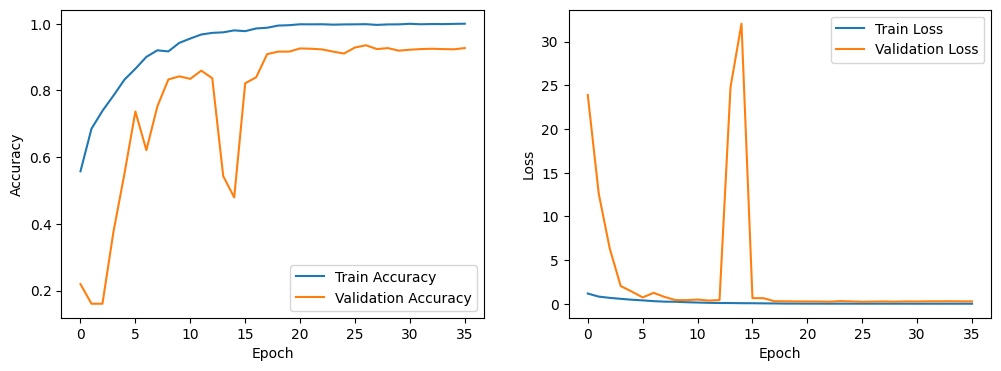

In [17]:
# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history)

In [35]:
# Evaluate on test set
test_gen = data_generator(X_test, y_test, batch_size=batch_size)
test_steps = len(X_test) // batch_size

loss, accuracy = model.evaluate(test_gen, steps=test_steps)
print(f"Test Accuracy: {accuracy*100:.2f}%")


33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 587ms/step - accuracy: 0.9274 - loss: 0.2315
Test Accuracy: 92.33%


In [36]:
# Function to predict on new audio
def predict_bird(audio_path, model, le):
    spectrogram = generate_mel_spectrogram(audio_path)
    if spectrogram is None:
        return "Error processing audio"

    # Add batch dimension
    spectrogram = np.expand_dims(spectrogram, axis=0)

    # Predict
    pred = model.predict(spectrogram)
    pred_class = np.argmax(pred, axis=1)

    # Get bird name
    bird_name = le.inverse_transform(pred_class)[0]
    confidence = np.max(pred) * 100

    return bird_name, confidence


In [37]:
# Example prediction
sample_file = X_test[0]
bird, confidence = predict_bird(sample_file, model, le)
print(f"Predicted: {bird} with {confidence:.2f}% confidence")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted: American Robin with 99.93% confidence


✅ Model loaded successfully


Saving 559279-3.wav to 559279-3.wav
🔊 Processing: 559279-3.wav


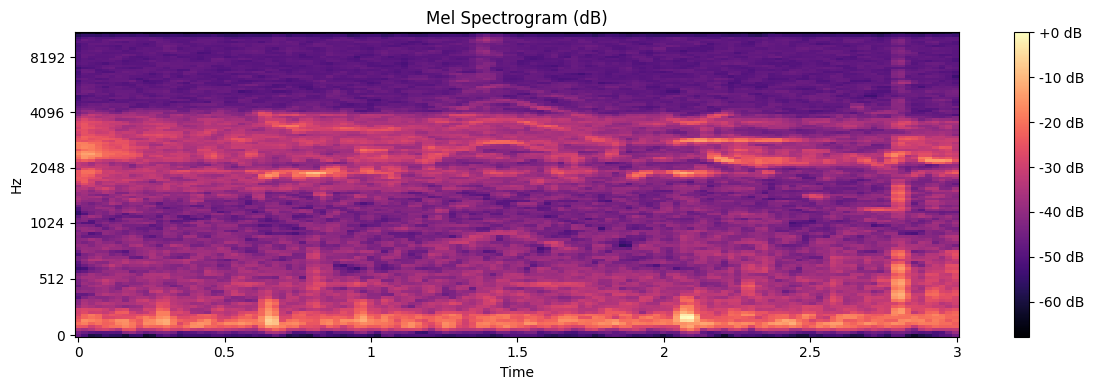

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step

🦜 Predicted species: Northern Cardinal
🔍 Confidence: 100.0%


In [24]:
import librosa
import librosa.display
import numpy as np
import tensorflow as tf
from google.colab import files
import IPython.display as ipd
import matplotlib.pyplot as plt

# Define the prediction function
def predict_bird_species(audio_file_path, model, le, duration=5):
    """Predicts the bird species from an audio file."""
    try:
        # Load and process audio
        audio_data, sample_rate = librosa.load(audio_file_path,
                                             sr=SAMPLE_RATE,
                                             duration=duration,
                                             mono=True)

        # If audio is shorter than duration, pad with zeros
        if len(audio_data) < sample_rate * duration:
            padding = sample_rate * duration - len(audio_data)
            audio_data = np.pad(audio_data, (0, padding), mode='constant')

        # Create mel spectrogram (using same parameters as training)
        mel_spec = librosa.feature.melspectrogram(y=audio_data,
                                                sr=sample_rate,
                                                n_fft=N_FFT,
                                                hop_length=HOP_LENGTH,
                                                n_mels=N_MELS)
        mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

        # Normalize and reshape to match training format
        mel_spec = (mel_spec - mel_spec.min()) / (mel_spec.max() - mel_spec.min())
        mel_spec = np.expand_dims(mel_spec, axis=-1)  # Add channel dimension
        mel_spec = np.expand_dims(mel_spec, axis=0)   # Add batch dimension

        # Predict
        prediction = model.predict(mel_spec)
        predicted_class_index = np.argmax(prediction)
        confidence = np.max(prediction)

        # Get bird name from label encoder
        bird_name = le.inverse_transform([predicted_class_index])[0]

        return bird_name, float(confidence)

    except Exception as e:
        print(f"Error processing {audio_file_path}: {str(e)}")
        return None, 0.0

# Now load model and make predictions
try:
    # Load model (use the one we trained or your saved model)
    # model = tf.keras.models.load_model('/content/drive/MyDrive/Optimized_Model/Finalmodel.h5')
    # Or use the model we just trained:
    if 'model' not in globals():
        model = tf.keras.models.load_model('best_model.h5')

    print("✅ Model loaded successfully")

    # Upload file
    uploaded = files.upload()
    if not uploaded:
        print("❌ No file uploaded")
    else:
        audio_file_path = list(uploaded.keys())[0]
        print(f"🔊 Processing: {audio_file_path}")

        # Play audio
        ipd.display(ipd.Audio(audio_file_path))

        # Show spectrogram with enhanced visualization
        plt.figure(figsize=(12, 4))
        audio_data, sr = librosa.load(audio_file_path, sr=SAMPLE_RATE)

        # Create mel spectrogram with same params as training
        S = librosa.feature.melspectrogram(y=audio_data, sr=sr,
                                         n_fft=N_FFT,
                                         hop_length=HOP_LENGTH,
                                         n_mels=N_MELS)
        S_dB = librosa.power_to_db(S, ref=np.max)

        # Display spectrogram
        librosa.display.specshow(S_dB, sr=sr,
                               hop_length=HOP_LENGTH,
                               x_axis='time',
                               y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Mel Spectrogram (dB)')
        plt.tight_layout()
        plt.show()

        # Make prediction
        species, confidence = predict_bird_species(audio_file_path, model, le)

        if species:
            print(f"\n🦜 Predicted species: {species}")
            print(f"🔍 Confidence: {confidence:.1%}")

            # Show top 3 predictions if you want
            if confidence < 0.7:  # Only show if confidence is low
                print("\nOther possible species:")
                preds = model.predict(np.expand_dims(S_dB, axis=(0, -1)))[0]
                top3 = np.argsort(preds)[-3:][::-1]
                for i, idx in enumerate(top3):
                    print(f"{i+1}. {le.inverse_transform([idx])[0]} ({preds[idx]:.1%})")
        else:
            print("❌ Could not make prediction")

except Exception as e:
    print(f"❌ Error: {e}")

In [39]:
# Save the trained model
from datetime import datetime
import os
import pickle

# Create directory for saved models if it doesn't exist
save_dir = '/content/drive/MyDrive/BirdCall_Models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Generate timestamp for versioning
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Save model in Keras .keras format (recommended)
model.save(f'{save_dir}/birdcall_model_{timestamp}.keras')

# Save model in HDF5 format (legacy)
model.save(f'{save_dir}/birdcall_model_{timestamp}.h5')

# Save the label encoder
with open(f'{save_dir}/label_encoder_{timestamp}.pkl', 'wb') as f:
    pickle.dump(le, f)

print(f"✅ Model and label encoder saved to {save_dir}")
print(f"Saved files:")
print(f"- birdcall_model_{timestamp}.keras (Native Keras format)")
print(f"- birdcall_model_{timestamp}.h5 (HDF5 format)")
print(f"- label_encoder_{timestamp}.pkl (Label encoder)")

✅ Model and label encoder saved to /content/drive/MyDrive/BirdCall_Models
Saved files:
- birdcall_model_20250403_210638.keras (Native Keras format)
- birdcall_model_20250403_210638.h5 (HDF5 format)
- label_encoder_20250403_210638.pkl (Label encoder)
